# Density Estimation using Mask Autoregressive Flow (MAF) on MNIST

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import random

from data.dataset_loader import load_and_preprocess_mnist, inverse_logit
from normalizingflows.flow_catalog import Made, BatchNorm, get_trainable_variables
from utils.train_utils import train_density_estimation, nll

tfd = tfp.distributions
tfb = tfp.bijectors

tf.random.set_seed(1234)

tensorflow:  2.0.0
tensorflow-probability:  0.8.0-rc0


In [2]:
tf.test.is_gpu_available()

True

In [3]:
# parameters
batch_size = 128
dataset = "mnist"
layers = 8
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(300)
shape = [256, 256]
exp_number = 1
mnist_trainsize = 50000

### Data loading and preprocessing

In [5]:
# define if training should happen on all classes or one specific class
# possibilities: int(1), int(2), ... , int(9), None
category = -1

In [6]:
# train: 50000, validation: 10000, test: 10000
batched_train_data, batched_val_data, batched_test_data, _ = load_and_preprocess_mnist(logit_space=True, batch_size=batch_size, classes=category)

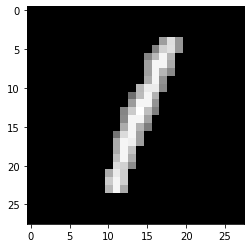

In [10]:
# assumes channels first
show = True
sample_batch = next(iter(batched_train_data))
if sample_batch.shape[-1] == sample_batch.shape[-2]:
    size = sample_batch.shape[-1]
    input_shape = size*size
else:
    print("Height and width of input data are not equal!")
    
if show:
    plt.imshow(sample_batch[0], cmap='gray')
    
permutation = tf.cast(np.concatenate((np.arange(input_shape/2,input_shape),np.arange(0,input_shape/2))), tf.int32)
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=input_shape, dtype=tf.float32))

### Create MAF flow

In [11]:
bijectors = []
event_shape = [size*size]

# According to [Papamakarios et al. (2017)]:
# BatchNorm between the last autoregressive layer and the base distribution, and every two autoregressive layers

bijectors.append(BatchNorm(eps=10e-5, decay=0.95))

for i in range(0, layers):

    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn = Made(params=2, hidden_units=shape, activation="relu")))
    bijectors.append(tfb.Permute(permutation=permutation)) # Permutation improves denstiy estimation results
    
    # add BatchNorm every two layers
    if (i+1) % int(2) == 0: 
        bijectors.append(BatchNorm(eps=10e-5, decay=0.95))


bijectors.append(tfb.Reshape(event_shape_out=(size,size), event_shape_in=(size*size,))) # reshape array to image shape, before: (size*size,)

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_maf')


maf = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
    # event_shape=[event_shape]
)

# important: initialize with log_prob to initialize the moving average of the layer statistics in the batch norm layers
maf.log_prob(sample_batch)  # initialize
print("Successfully initialized!")

Successfully initialized!


In [12]:
n_trainable_variables = get_trainable_variables(maf)
print(n_trainable_variables)

5365664


In [13]:
# learning rate scheduling
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [14]:
# initialize checkpoints
checkpoint_directory = "{}/tmp_{}_{}".format(dataset, layers, shape[0])
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=maf)

In [ ]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 50  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    
    batched_train_data.shuffle(buffer_size=mnist_trainsize, reshuffle_each_iteration=True)
    batch_train_losses = []
    for batch in batched_train_data:
        batch_loss = train_density_estimation(maf, opt, batch)
        batch_train_losses.append(batch_loss)
        
    train_loss = tf.reduce_mean(batch_train_losses)

    if i % int(1) == 0:
        batch_val_losses = []
        for batch in batched_val_data:
            batch_loss = nll(maf, batch)
            batch_val_losses.append(batch_loss)
                
        val_loss = tf.reduce_mean(batch_val_losses)
        
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i
            
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i
            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

train_time = time.time() - t_start

In [12]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()

test_losses = []
for batch in batched_test_data:
    batch_loss = nll(maf, batch)
    test_losses.append(batch_loss)
    
test_loss = tf.reduce_mean(test_losses)

test_time = time.time() - t_start

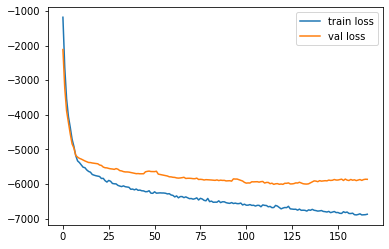

In [13]:
# plot train and validation loss curve
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.legend()

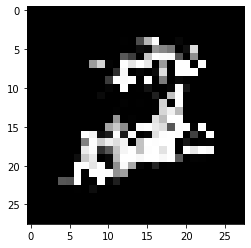

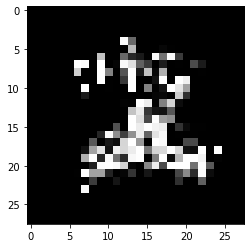

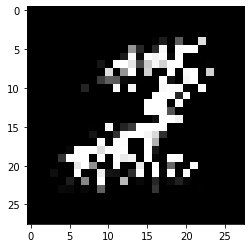

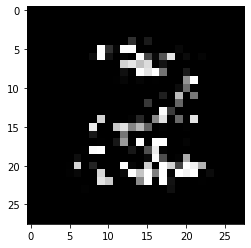

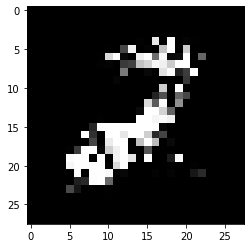

In [14]:
n_images = 5
save_dir = "{}/mnist_{}/sampling_{}_{}_{}_{}_{}".format(dataset, category, layers, shape[0], shape[1], exp_number,
                                                      min_val_epoch)
save = True

for i in range(n_images):
    plt.figure()
    data = maf.sample(2)
    data = inverse_logit(data)
    data = tf.reshape(data, (2,size,size))
    plt.imshow(data[0], cmap='gray')
    if save:
        plt.savefig(save_dir + "_i" + str(i) + ".png", format="png")